In [1]:
import numpy as np
import pandas as pd
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
# 3-D plots a single scan

def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [3]:
# load list of patients by directory in data

path_data = '/home/gantos/data/stage1/'

# slice patients
start, end = [0, 1]
patients = os.listdir(path_data)[start:end]

In [10]:
# Loads a single scan from given folder path

def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [22]:
# load_scan example dictionary

load_scan_dict = {}
load_scan_array_dict = {}

for patient in patients:
    load_scan_dict[patient] = load_scan(path_data + patient)
    load_scan_array_dict[patient] = np.stack([s.pixel_array for s in load_scan_dict[patient]]).astype(np.int16)

(167, 512, 512)


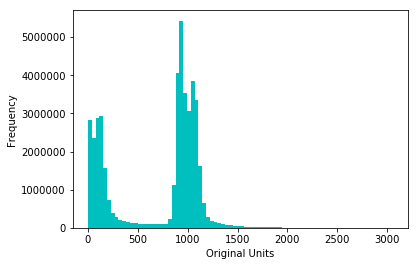

In [23]:
# print sizes and plot pixel intensity distributions

for patient in patients:
    print (load_scan_array_dict[patient].shape)
    plt.hist(load_scan_array_dict[patient].flatten(), bins=80, color='c')
    plt.xlabel("Original Units")
    plt.ylabel("Frequency")
    plt.show()

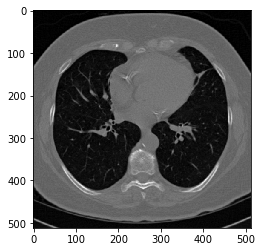

In [24]:
# print some slice in the middle of each patient

for patient in patients:
    plt.imshow(load_scan_array_dict[patient][80], cmap=plt.cm.gray)
    plt.show()

In [ ]:
# 3D plot each patient

for patient in patients[0:1]:
    plot_3d(load_scan_array_dict[patient], 400)

In [9]:
# convert the single scan values into Hounsfield Units (HUs)

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [10]:
# get_pixels_hu example dictionary

get_pixels_hu_dict = {}

for patient in patients:
    get_pixels_hu_dict[patient] = get_pixels_hu(load_scan_dict[patient])

(167, 512, 512)


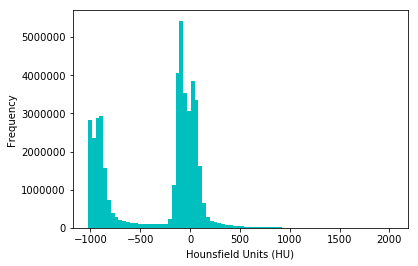

In [11]:
# print sizes and plot pixel intensity distributions

for patient in patients:
    print (get_pixels_hu_dict[patient].shape)
    plt.hist(get_pixels_hu_dict[patient].flatten(), bins=80, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()

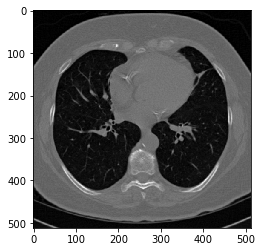

In [12]:
# print some slice in the middle of each patient

for patient in patients:
    plt.imshow(get_pixels_hu_dict[patient][80], cmap=plt.cm.gray)
    plt.show()

In [ ]:
# 3D plot each patient

for patient in patients:
    plot_3d(get_pixels_hu_dict[patient], 400)

In [13]:
# segments a single scan between lung and non-lung

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [14]:
# segment_lung_mask example dictionary

segment_lung_mask_dict = {}

for patient in patients:
    segment_lung_mask_dict[patient] = segment_lung_mask(get_pixels_hu_dict[patient])

(167, 512, 512)


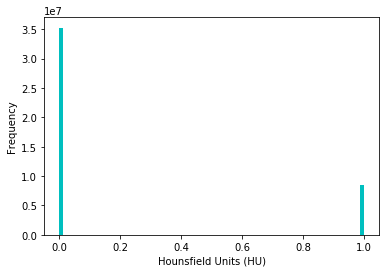

In [15]:
# print sizes and plot pixel intensity distributions

for patient in patients:
    print (segment_lung_mask_dict[patient].shape)
    plt.hist(segment_lung_mask_dict[patient].flatten(), bins=80, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()

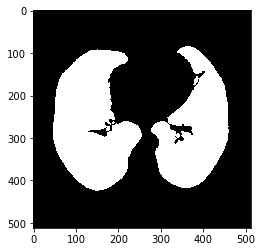

In [16]:
# print some slice in the middle of each patient

for patient in patients:
    plt.imshow(segment_lung_mask_dict[patient][80], cmap=plt.cm.gray)
    plt.show()

In [ ]:
# 3D plot each patient

for patient in patients:
    plot_3d(segment_lung_mask_dict[patient], 0)

In [18]:
# adjusts the single scan to have slices exactly 'z'cm distance from one another
# along the z-, x-, and y-axs

def resample(image,
             scan,
             new_spacing = [3,3,3]): # set distance in cm between each slice and between pixels
    
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)
    print('        Original spacing', spacing)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    print('        Resampled spacing', new_spacing)
    
    print("        Shape before resampling\t", image.shape)
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    print("        Shape after resampling\t", image.shape)

    return image, new_spacing

In [19]:
# resample example dictionary

resample_dict = {}

for patient in patients:
    print (patient)
    resample_dict[patient],_ = resample(segment_lung_mask_dict[patient], load_scan_dict[patient])

b0599ad2f33276e7cd065eaa8dcec8a2
        Original spacing [ 1.79999995  0.59765625  0.59765625]
        Resampled spacing [ 3.00599992  3.          3.        ]
        Shape before resampling	 (167, 512, 512)


/home/gantos/.local/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


        Shape after resampling	 (100, 102, 102)


(100, 102, 102)


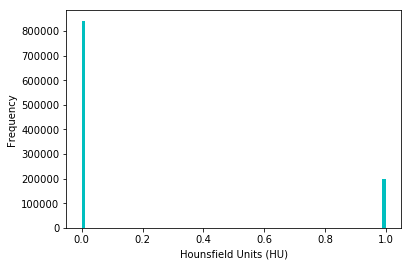

In [27]:
# print sizes and plot pixel intensity distributions

for patient in patients:
    print (resample_dict[patient].shape)
    plt.hist(resample_dict[patient].flatten(), bins=80, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()

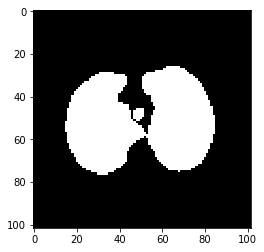

In [28]:
# print some slice in the middle of each patient

for patient in patients:
    plt.imshow(resample_dict[patient][80], cmap=plt.cm.gray)
    plt.show()

In [ ]:
# 3D plot each patient

for patient in patients:
    plot_3d(resample_dict[patient], 400)

In [29]:
# removes zero-arrays from all axes of a single scan

def remove_zeros(nparray):
    print ('        Original shape..', nparray.shape)
    zaxis = np.stack([z for z in nparray if np.sum(z) != 0])
    print ('        Shape after z-axis sliced..', zaxis.shape)
    xaxis = np.swapaxes(np.stack([x for x in np.swapaxes(zaxis,0,1) if np.sum(x) != 0]), 0,1)
    print ('        Shape after x-axis sliced..', xaxis.shape)
    yaxis = np.swapaxes(np.stack([y for y in np.swapaxes(xaxis,0,2) if np.sum(y) != 0]), 0,2)
    print ('        Shape after y-axis sliced..', yaxis.shape)
    
    return yaxis

In [31]:
# remove_zeros example dictionary

remove_zeros_dict = {}

for patient in patients:
    print (patient)
    remove_zeros_dict[patient] = remove_zeros(resample_dict[patient])

b0599ad2f33276e7cd065eaa8dcec8a2
        Original shape.. (100, 102, 102)
        Shape after z-axis sliced.. (94, 102, 102)
        Shape after x-axis sliced.. (94, 67, 102)
        Shape after y-axis sliced.. (94, 67, 95)


(94, 67, 95)


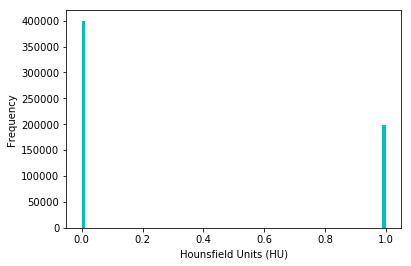

In [32]:
# print sizes and plot pixel intensity distributions

for patient in patients:
    print (remove_zeros_dict[patient].shape)
    plt.hist(remove_zeros_dict[patient].flatten(), bins=80, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()

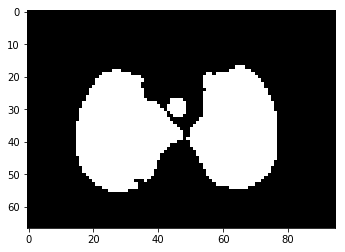

In [33]:
# print some slice in the middle of each patient

for patient in patients:
    plt.imshow(remove_zeros_dict[patient][80], cmap=plt.cm.gray)
    plt.show()

In [ ]:
# 3D plot each patient

for patient in patients:
    plot_3d(remove_zeros_dict[patient], 0)

In [35]:
# adds zero-arrays to all axes of a single scan to create uniform volume sizes

zxy_max = [0,0,0]
for patient in patients:
    zxy_patient = remove_zeros_dict[patient].shape
    zxy_max = list(map(max, zip(zxy_max, zxy_patient)))

def add_zeros(nparray, zxy_max=zxy_max):
    
    print ('    Original shape..', nparray.shape)
    zMax, xMax, yMax = zxy_max
    z, x, y = nparray.shape
    
    if z < zMax:
        extraSlices = np.zeros((zMax-z, x, y))
        nparray = np.concatenate((nparray, extraSlices), axis=0)
        z, x, y = nparray.shape
        print ('    Shape after zeros added to z-axis..', nparray.shape)
        
    if x < xMax:
        extraSlices = np.zeros((z, xMax-x, y))
        nparray = np.concatenate((nparray, extraSlices), axis=1)
        z, x, y = nparray.shape
        print ('    Shape after zeros added to x-axis..', nparray.shape)    
            
    if y < yMax:
        extraSlices = np.zeros((z, x, yMax-y))
        nparray = np.concatenate((nparray, extraSlices), axis=2)
        z, x, y = nparray.shape
        print ('    Shape after zeros added to y-axis..', nparray.shape)
    
    return nparray

In [36]:
# add_zeros example dictionary

add_zeros_dict = {}

for patient in patients:
    print (patient)
    add_zeros_dict[patient] = add_zeros(remove_zeros_dict[patient])

b0599ad2f33276e7cd065eaa8dcec8a2
    Original shape.. (94, 67, 95)


(94, 67, 95)


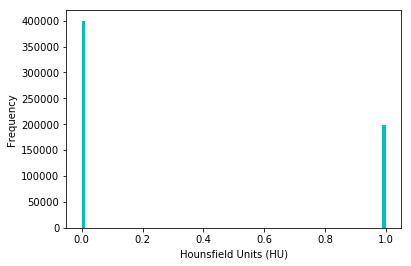

In [37]:
# print sizes and plot pixel intensity distributions

for patient in patients:
    print (add_zeros_dict[patient].shape)
    plt.hist(add_zeros_dict[patient].flatten(), bins=80, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()

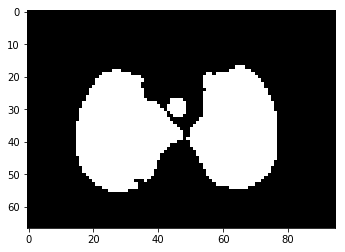

In [38]:
# print some slice in the middle of each patient

for patient in patients:
    plt.imshow(add_zeros_dict[patient][80], cmap=plt.cm.gray)
    plt.show()

In [ ]:
# 3D plot each patient

for patient in patients:
    plot_3d(add_zeros_dict[patient], 0)

Number of arrays.. 1
Shape of each array.. (94, 67, 95)


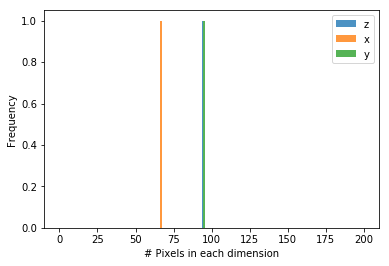

In [40]:
# Check that all of the patients are the same shape

dimensions=[]
for patient in patients:
    dimensions.append(add_zeros_dict[patient].shape)
    
print ('Number of arrays..', len(dimensions))
print ('Shape of each array..', dimensions[0])

bins = np.linspace(0, 200, 200)
plt.hist([x[0] for x in dimensions], bins, alpha=0.8, label='z')
plt.hist([x[1] for x in dimensions], bins, alpha=0.8, label='x')
plt.hist([x[2] for x in dimensions], bins, alpha=0.8, label='y')
plt.legend(loc='upper right')
plt.xlabel("# Pixels in each dimension")
plt.ylabel("Frequency")
plt.show()